In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random

from neurovae import DNNVAE, bce_loss, gaussian_kld, load_mnist, plot_digits

from plot_utils import save_comparison, save_samples

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

In [2]:
def run(latent_dim):

    hidden_dims = (500, 150)
    output_dim = 784
    batch_size = 64
    epochs = 100
    seed = 42

    batches, ds_test = load_mnist(
        batch_size=batch_size,
        drop_remainder=True,
        select_digits=[0, 1, 2, 3],
        as_supervised=False,
        binarized=True,
        shuffle=True,
        shuffle_seed=42,
    )

    # set values for learning rate scheduler
    total_steps = len(batches) * epochs
    init_lr = 1e-3
    alpha_lr = 1e-2

    ds_test = jax.device_put(ds_test)

    def model():
        return DNNVAE(hidden_dims, latent_dim, output_dim)

    def init_model(rng):
        rng, init_key = random.split(rng)

        initial_variables = jnp.ones((batch_size, output_dim), jnp.float32)
        params = model().init(init_key, initial_variables, rng)["params"]
        del initial_variables, init_key

        lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
        optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule, nesterov=True))

        state = train_state.TrainState.create(
            apply_fn=model().apply,
            params=params,
            tx=optimizer,
        )
        return rng, state

    def compute_metrics(recon_x, x, mean, logvar):
        bce = bce_loss(recon_x, x).mean()  # mean over batch
        kld = gaussian_kld(mean, logvar).mean()  # mean over batch
        elbo = bce + kld
        return {"elbo": elbo, "bce": bce, "kld": kld}

    @jax.jit
    def train_step(state, batch, z_rng):

        def loss_fn(params):
            recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
            bce = bce_loss(recon_x, batch).mean()
            kld = gaussian_kld(mean, logvar).mean()
            elbo = bce + kld
            return elbo

        grads = jax.grad(loss_fn)(state.params)
        return state.apply_gradients(grads=grads)

    @jax.jit
    def eval_f(params, images, z, z_rng):
        def eval_model(vae):
            recon_images, mean, logvar = vae(images, z_rng)

            recon_images_compare = nn.sigmoid(recon_images[:8])
            comparison = jnp.concatenate(
                [
                    images[:8].reshape(-1, 28, 28, 1),
                    recon_images_compare.reshape(-1, 28, 28, 1),
                ]
            )

            generate_images = vae.generate(z, assumption="bernoulli")
            generate_images = generate_images.reshape(-1, 28, 28, 1)
            metrics = compute_metrics(recon_images, images, mean, logvar)
            return metrics, comparison, generate_images

        return nn.apply(eval_model, model())({"params": params})

    rng = random.key(seed)
    rng, state = init_model(rng)

    rng, z_key, eval_rng = random.split(rng, 3)

    z = random.normal(z_key, (batch_size, latent_dim))  # prior
    del z_key

    epoch_metrics = []
    for epoch in range(epochs):
        for batch in batches:
            rng, key = random.split(rng)
            state = train_step(state, batch, key)

        metrics, comparison, samples = eval_f(state.params, ds_test, z, eval_rng)
        metrics["epoch"] = epoch + 1
        epoch_metrics.append(metrics)
        print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")

    df = pd.DataFrame(epoch_metrics)
    df.to_csv(f"./vae_data/latent_dim_{latent_dim}_vanilla_dnn_vae_bmnist.csv", index=False)
    save_comparison(comparison, f"recon_latent_dim_{latent_dim}_vanilla_dnn_vae_bmnist.pdf")
    save_samples(samples, f"samples_latent_dim_{latent_dim}_vanilla_dnn_vae_bmnist.pdf")

epoch: 1, ELBO: 167.7050, BCE: 164.5121, KLD: 3.1929
epoch: 2, ELBO: 161.0431, BCE: 157.7876, KLD: 3.2555
epoch: 3, ELBO: 158.0677, BCE: 154.6725, KLD: 3.3952
epoch: 4, ELBO: 155.1322, BCE: 151.5773, KLD: 3.5549
epoch: 5, ELBO: 152.4329, BCE: 148.7405, KLD: 3.6923
epoch: 6, ELBO: 150.3320, BCE: 146.4932, KLD: 3.8388
epoch: 7, ELBO: 149.0183, BCE: 145.3076, KLD: 3.7107
epoch: 8, ELBO: 148.2614, BCE: 144.2631, KLD: 3.9983
epoch: 9, ELBO: 147.3133, BCE: 143.3919, KLD: 3.9214
epoch: 10, ELBO: 146.2943, BCE: 142.4702, KLD: 3.8242
epoch: 11, ELBO: 146.1567, BCE: 142.1142, KLD: 4.0424
epoch: 12, ELBO: 146.0247, BCE: 142.0631, KLD: 3.9616
epoch: 13, ELBO: 144.6289, BCE: 140.6291, KLD: 3.9998
epoch: 14, ELBO: 144.0693, BCE: 140.0549, KLD: 4.0144
epoch: 15, ELBO: 143.8460, BCE: 139.9185, KLD: 3.9275
epoch: 16, ELBO: 143.7307, BCE: 139.7793, KLD: 3.9515
epoch: 17, ELBO: 143.5817, BCE: 139.4967, KLD: 4.0850
epoch: 18, ELBO: 143.2101, BCE: 139.1378, KLD: 4.0722
epoch: 19, ELBO: 142.4013, BCE: 138.3

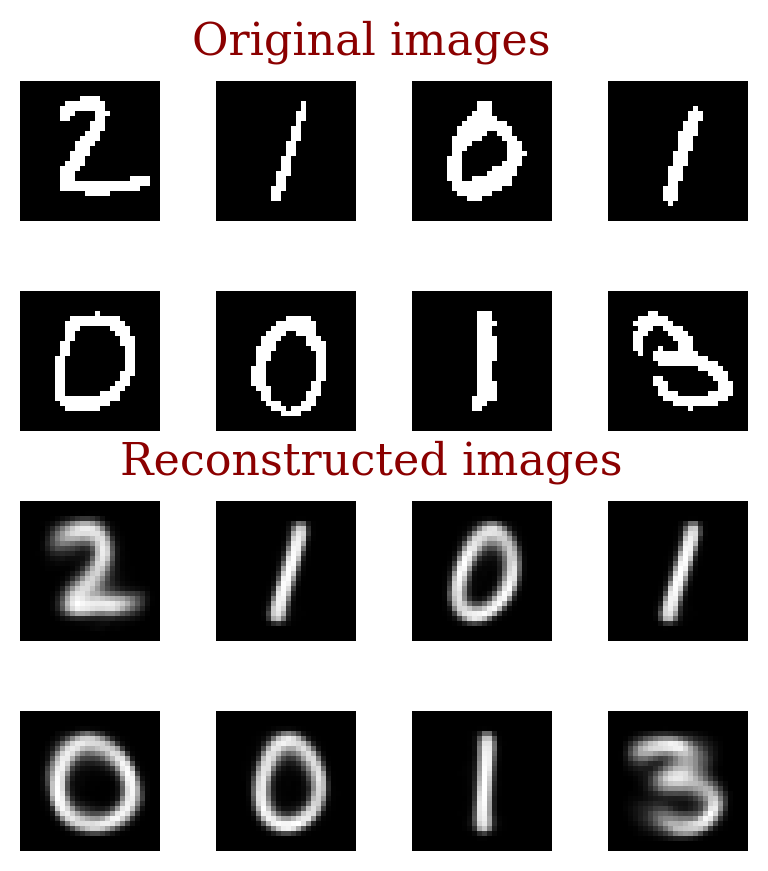

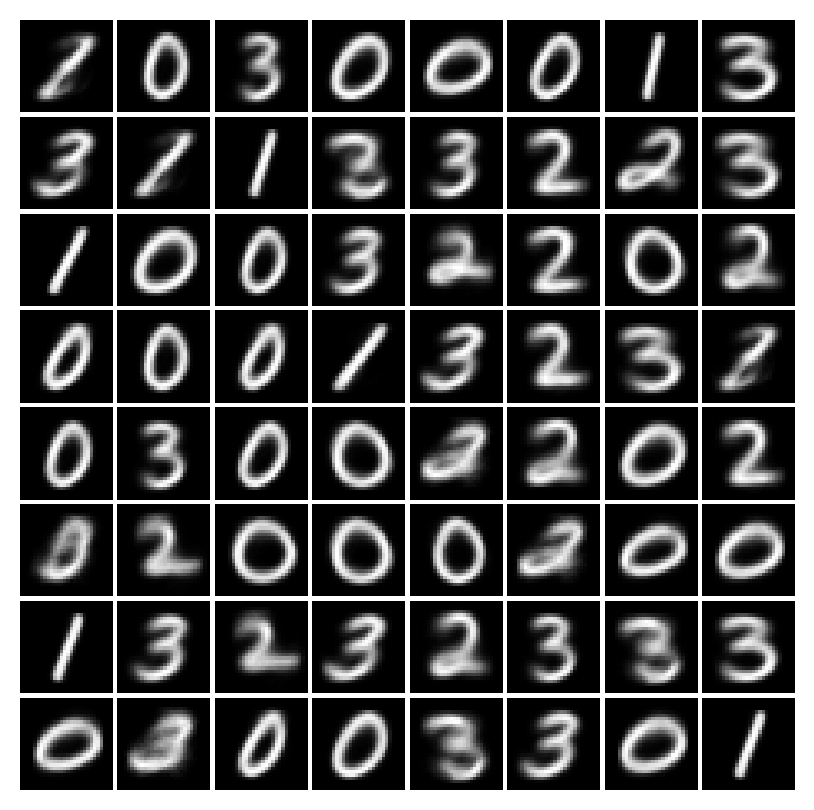

In [3]:
run(1)

epoch: 1, ELBO: 101.8877, BCE: 84.4966, KLD: 17.3912
epoch: 2, ELBO: 93.6762, BCE: 75.6942, KLD: 17.9820
epoch: 3, ELBO: 90.5228, BCE: 72.0880, KLD: 18.4347
epoch: 4, ELBO: 88.2754, BCE: 69.8262, KLD: 18.4493
epoch: 5, ELBO: 86.5950, BCE: 67.8838, KLD: 18.7112
epoch: 6, ELBO: 85.5828, BCE: 66.7621, KLD: 18.8208
epoch: 7, ELBO: 84.9801, BCE: 65.9565, KLD: 19.0236
epoch: 8, ELBO: 84.0467, BCE: 64.4433, KLD: 19.6033
epoch: 9, ELBO: 83.6665, BCE: 64.7367, KLD: 18.9298
epoch: 10, ELBO: 82.9957, BCE: 63.7901, KLD: 19.2056
epoch: 11, ELBO: 82.5597, BCE: 62.6811, KLD: 19.8786
epoch: 12, ELBO: 82.1222, BCE: 63.0202, KLD: 19.1020
epoch: 13, ELBO: 81.9893, BCE: 62.3504, KLD: 19.6390
epoch: 14, ELBO: 81.7730, BCE: 62.1823, KLD: 19.5908
epoch: 15, ELBO: 81.4036, BCE: 62.0014, KLD: 19.4021
epoch: 16, ELBO: 81.6075, BCE: 61.7777, KLD: 19.8298
epoch: 17, ELBO: 81.3398, BCE: 61.4058, KLD: 19.9340
epoch: 18, ELBO: 81.1421, BCE: 61.4429, KLD: 19.6993
epoch: 19, ELBO: 81.0273, BCE: 61.4101, KLD: 19.6172
e

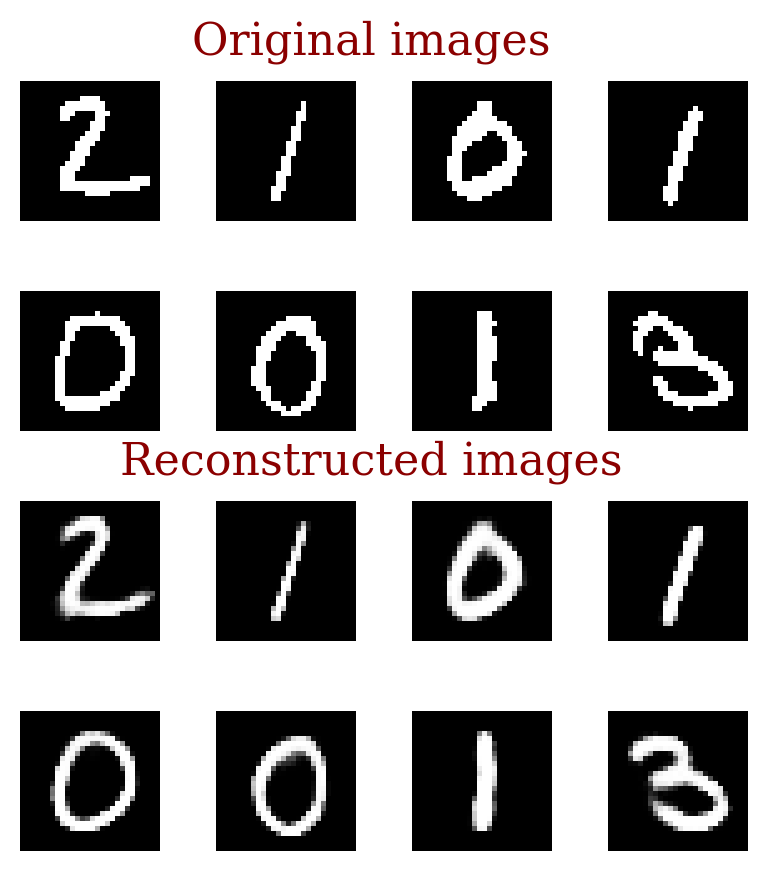

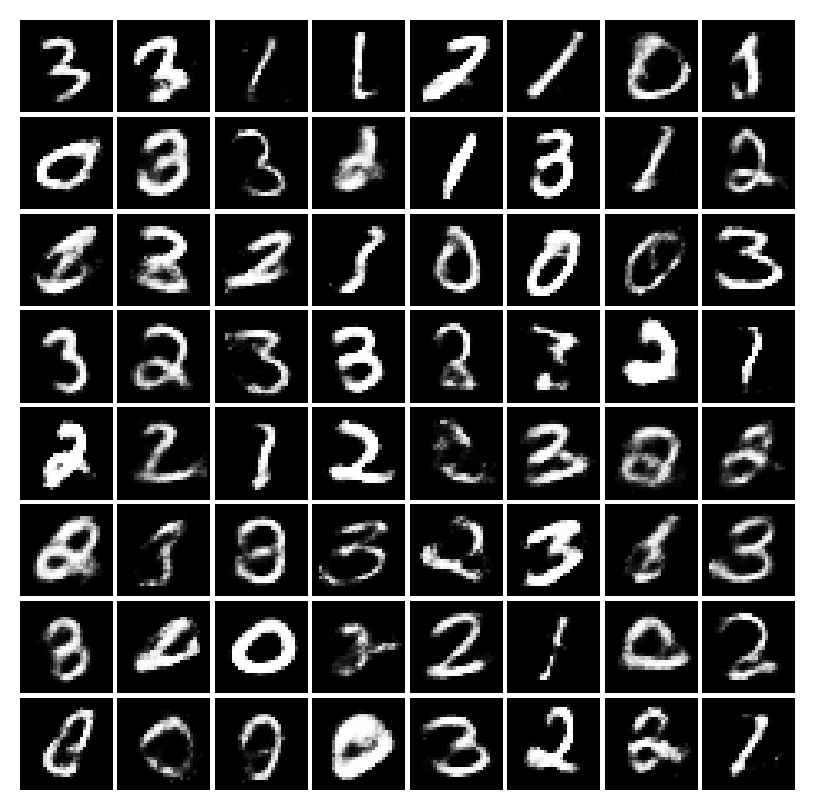

In [4]:
run(10)

epoch: 1, ELBO: 104.2366, BCE: 82.9829, KLD: 21.2537
epoch: 2, ELBO: 93.8156, BCE: 71.1404, KLD: 22.6752
epoch: 3, ELBO: 88.9883, BCE: 64.9084, KLD: 24.0799
epoch: 4, ELBO: 86.8610, BCE: 62.0268, KLD: 24.8342
epoch: 5, ELBO: 84.7231, BCE: 59.1089, KLD: 25.6142
epoch: 6, ELBO: 83.8887, BCE: 58.9666, KLD: 24.9221
epoch: 7, ELBO: 82.9028, BCE: 57.4916, KLD: 25.4112
epoch: 8, ELBO: 82.3424, BCE: 56.5507, KLD: 25.7916
epoch: 9, ELBO: 81.2458, BCE: 55.8865, KLD: 25.3592
epoch: 10, ELBO: 81.0022, BCE: 55.0840, KLD: 25.9183
epoch: 11, ELBO: 80.5489, BCE: 54.8451, KLD: 25.7038
epoch: 12, ELBO: 80.4328, BCE: 54.6374, KLD: 25.7954
epoch: 13, ELBO: 79.9490, BCE: 53.5676, KLD: 26.3813
epoch: 14, ELBO: 79.5779, BCE: 53.6798, KLD: 25.8981
epoch: 15, ELBO: 79.3405, BCE: 52.6545, KLD: 26.6860
epoch: 16, ELBO: 79.1943, BCE: 52.8308, KLD: 26.3636
epoch: 17, ELBO: 78.6370, BCE: 51.7681, KLD: 26.8689
epoch: 18, ELBO: 78.9323, BCE: 52.5985, KLD: 26.3338
epoch: 19, ELBO: 78.7236, BCE: 52.6872, KLD: 26.0364
e

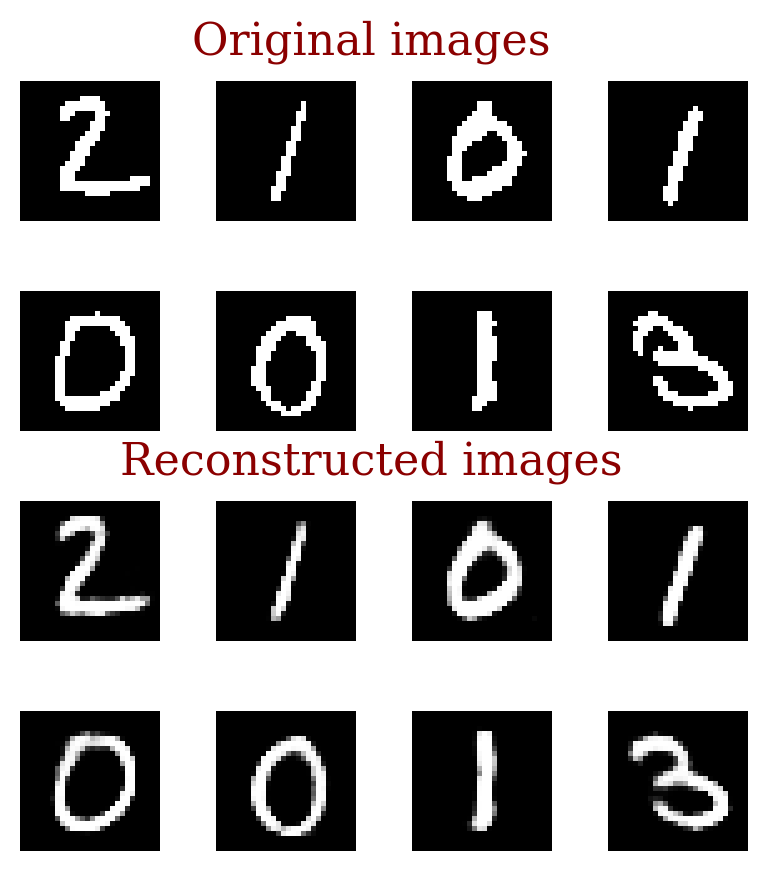

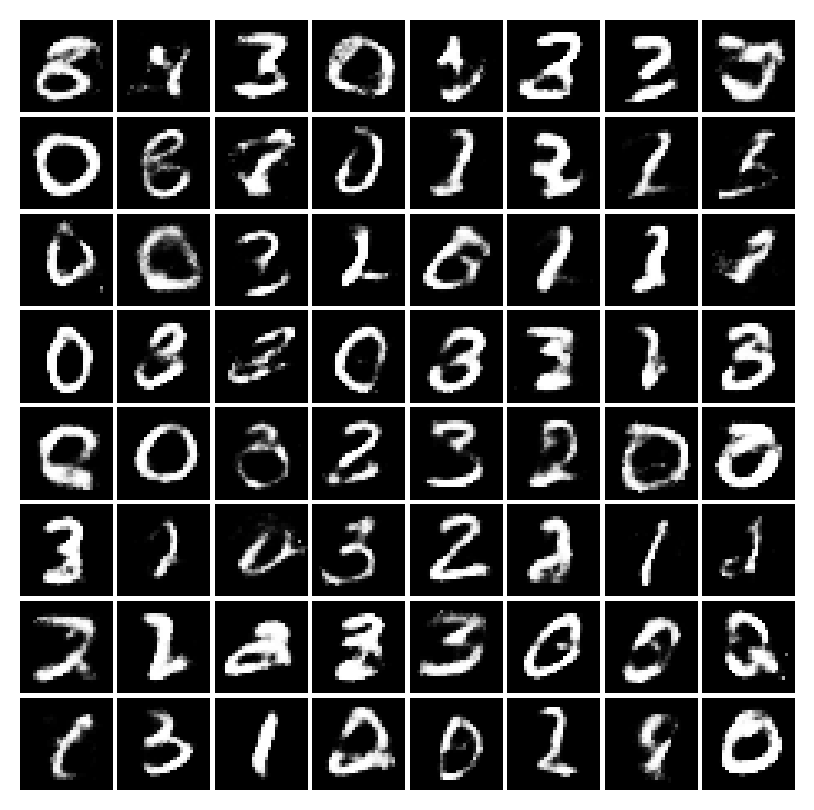

In [5]:
run(20)

epoch: 1, ELBO: 120.1971, BCE: 97.8221, KLD: 22.3750
epoch: 2, ELBO: 105.8412, BCE: 80.3458, KLD: 25.4954
epoch: 3, ELBO: 97.8825, BCE: 73.2752, KLD: 24.6073
epoch: 4, ELBO: 92.7103, BCE: 67.3328, KLD: 25.3775
epoch: 5, ELBO: 89.2212, BCE: 64.4868, KLD: 24.7343
epoch: 6, ELBO: 86.7510, BCE: 61.4615, KLD: 25.2895
epoch: 7, ELBO: 84.7703, BCE: 59.8961, KLD: 24.8743
epoch: 8, ELBO: 83.7469, BCE: 58.1748, KLD: 25.5722
epoch: 9, ELBO: 82.8241, BCE: 57.0896, KLD: 25.7345
epoch: 10, ELBO: 82.0336, BCE: 56.8819, KLD: 25.1517
epoch: 11, ELBO: 80.8181, BCE: 55.7552, KLD: 25.0629
epoch: 12, ELBO: 80.1066, BCE: 54.5291, KLD: 25.5775
epoch: 13, ELBO: 80.0644, BCE: 54.1464, KLD: 25.9180
epoch: 14, ELBO: 79.2604, BCE: 53.3903, KLD: 25.8702
epoch: 15, ELBO: 79.6167, BCE: 53.6824, KLD: 25.9343
epoch: 16, ELBO: 78.6517, BCE: 53.2556, KLD: 25.3961
epoch: 17, ELBO: 78.2546, BCE: 51.6558, KLD: 26.5988
epoch: 18, ELBO: 78.4884, BCE: 51.8912, KLD: 26.5971
epoch: 19, ELBO: 77.9145, BCE: 51.4322, KLD: 26.4823


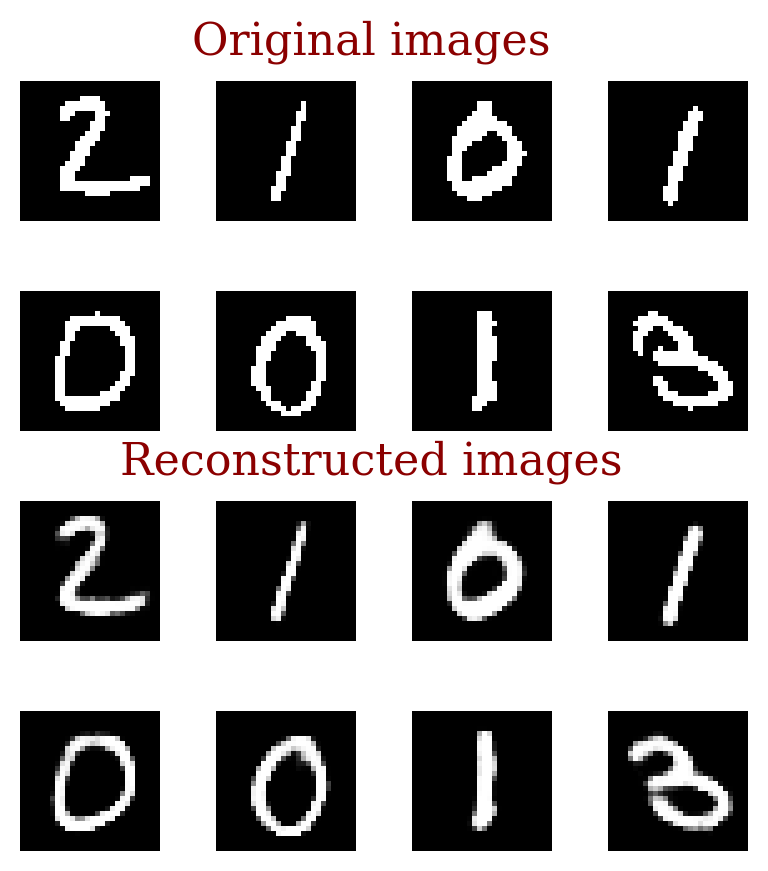

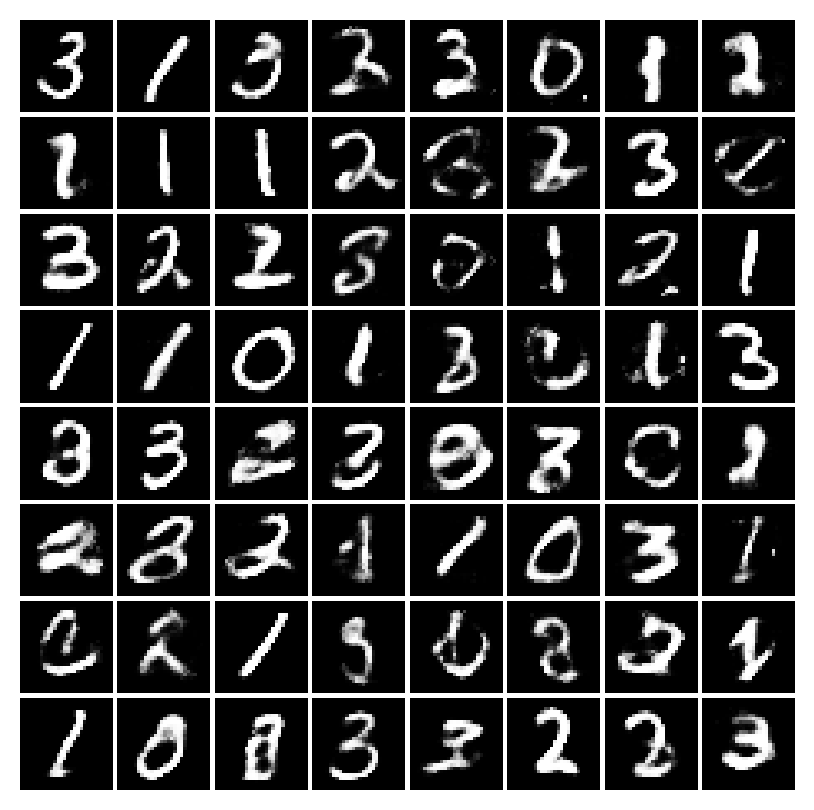

In [6]:
run(50)

epoch: 1, ELBO: 131.2523, BCE: 111.6988, KLD: 19.5534
epoch: 2, ELBO: 118.0446, BCE: 96.5491, KLD: 21.4955
epoch: 3, ELBO: 108.4246, BCE: 85.9960, KLD: 22.4285
epoch: 4, ELBO: 101.1252, BCE: 78.7237, KLD: 22.4016
epoch: 5, ELBO: 95.5895, BCE: 72.8557, KLD: 22.7338
epoch: 6, ELBO: 90.9457, BCE: 68.5719, KLD: 22.3738
epoch: 7, ELBO: 88.0461, BCE: 65.1164, KLD: 22.9297
epoch: 8, ELBO: 85.5617, BCE: 62.4494, KLD: 23.1123
epoch: 9, ELBO: 83.9651, BCE: 60.3723, KLD: 23.5927
epoch: 10, ELBO: 82.5317, BCE: 58.9013, KLD: 23.6304
epoch: 11, ELBO: 81.9704, BCE: 58.6141, KLD: 23.3563
epoch: 12, ELBO: 81.0036, BCE: 57.6197, KLD: 23.3839
epoch: 13, ELBO: 80.4569, BCE: 56.2838, KLD: 24.1731
epoch: 14, ELBO: 79.8177, BCE: 56.2015, KLD: 23.6162
epoch: 15, ELBO: 79.3185, BCE: 55.6855, KLD: 23.6330
epoch: 16, ELBO: 79.2317, BCE: 54.8285, KLD: 24.4031
epoch: 17, ELBO: 78.9242, BCE: 55.4854, KLD: 23.4389
epoch: 18, ELBO: 78.6139, BCE: 54.4283, KLD: 24.1856
epoch: 19, ELBO: 78.1087, BCE: 53.8030, KLD: 24.30

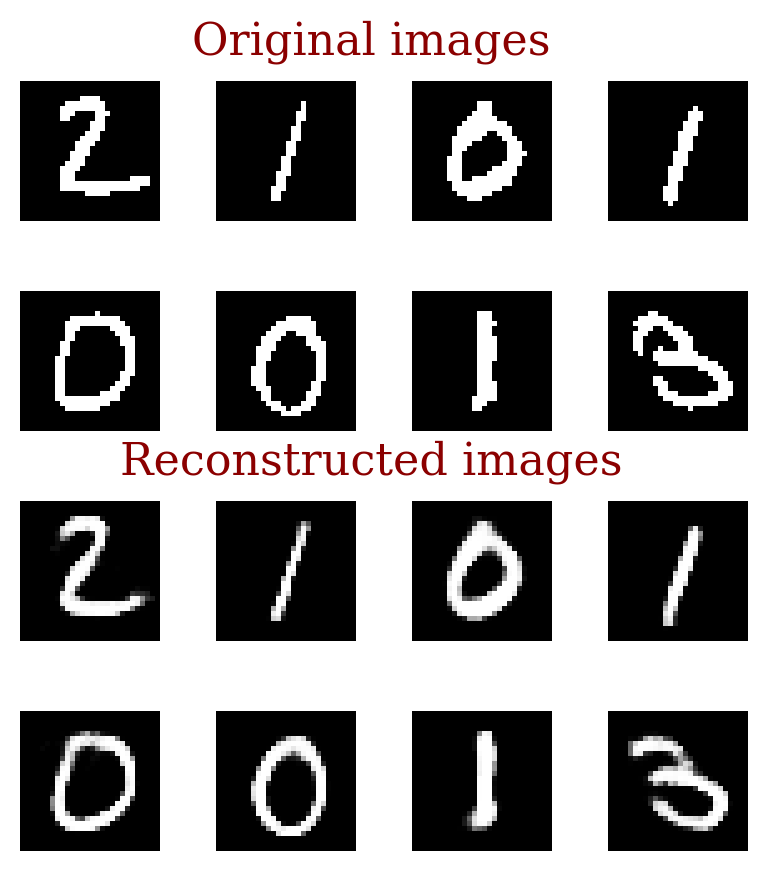

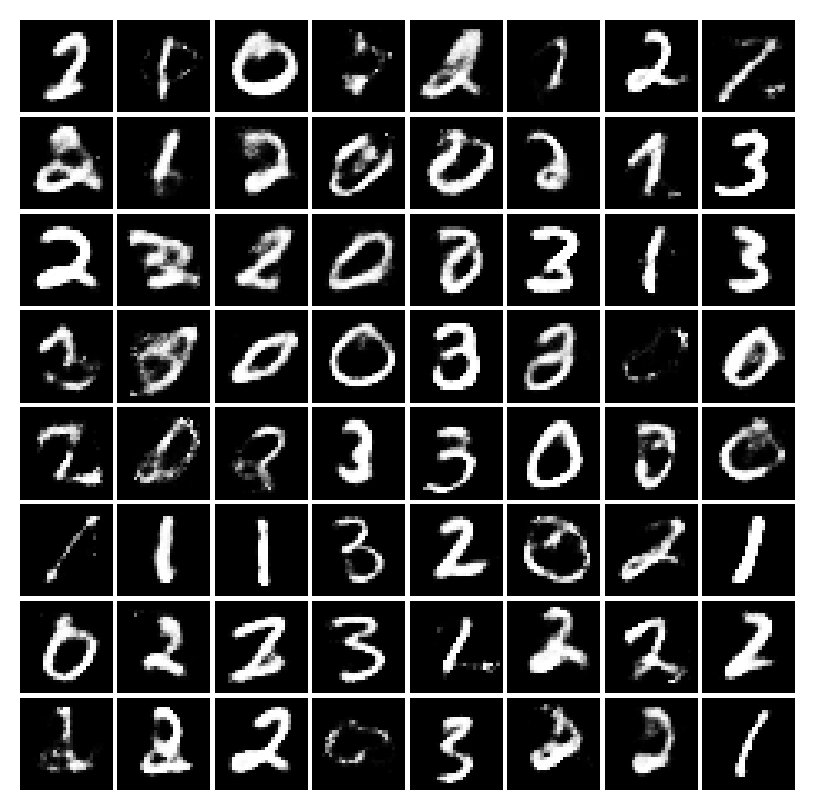

In [7]:
run(100)